In [1]:
import pandas as pd
import torch   

#handling text data
from torchtext.legacy import data  


In [2]:
from google.colab import drive;
drive.mount("/content/drive");

Mounted at /content/drive


In [3]:
dataset=pd.read_csv('/content/drive/MyDrive/00SoftLab/ass3/Dataset 3.csv',encoding='ISO-8859-1')
dataset

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [4]:
import re
def remove(text):
    return re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)

In [5]:
dataset['tweets'] = dataset['tweets'].apply(lambda x: remove(x))
dataset.drop(10313,inplace=True)
dataset

,tweets,sentiment
0,just had a real good moment i missssssssss him...,0
1,is reading manga httpplurkcompmzp1e,0
2,comeagainjen httptwitpiccom2y2lx httpwwwyoutu...,0
3,lapcat Need to send 'em to my accountant tomor...,0
4,ADD ME ON MYSPACE myspacecomLookThunder,0
...,...,...
10308,Many sufferers of depression aren't sad they f...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [6]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.to_csv('data.csv',index=False)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense

In [8]:
voc_size=5000
import nltk
import re
from nltk.corpus import stopwords

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(dataset)):
    
    review = re.sub('[^a-zA-Z]', ' ', dataset['tweets'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [11]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [12]:
dataset

,tweets,sentiment
0,i look super cute today my depression is easing,1
1,Doing the things I have to get done before the...,0
2,Last time I checked this is still a Free Count...,0
3,you can see the coffee table again dagnyreardo...,0
4,Just got home sleep time,0
...,...,...
10308,thinking of my inspiration wassup,0
10309,the end of 2014 2016 was my worst yrs Emoji ...,1
10310,is watching Mario Barth,0
10311,25 manipedi denovo only for today offer good...,0


In [13]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
print(embedded_docs)

[[3994  558  987 ...    0    0    0]
 [ 134 4219  860 ...    0    0    0]
 [1720  158  287 ...    0    0    0]
 ...
 [3025 4994  427 ...    0    0    0]
 [2522 2057  298 ...    0    0    0]
 [ 739  693 3663 ...    0    0    0]]


In [14]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(32,return_sequences=True,input_shape=(3,1)))
model.add(LSTM(16,return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 40, 32)            9344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 16)            3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 213,289
Trainable params: 213,289
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(dataset.sentiment)

In [16]:
y_final

array([1, 0, 0, ..., 0, 0, 0])

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2,random_state=42)

In [18]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
129/129 [==============================] - 15s 41ms/step - loss: 0.4387 - accuracy: 0.8299 - val_loss: 0.2040 - val_accuracy: 0.9569
Epoch 2/10
129/129 [==============================] - 4s 32ms/step - loss: 0.1067 - accuracy: 0.9832 - val_loss: 0.0724 - val_accuracy: 0.9859
Epoch 3/10
129/129 [==============================] - 4s 32ms/step - loss: 0.0431 - accuracy: 0.9936 - val_loss: 0.0509 - val_accuracy: 0.9884
Epoch 4/10
129/129 [==============================] - 4s 32ms/step - loss: 0.0253 - accuracy: 0.9966 - val_loss: 0.0563 - val_accuracy: 0.9874
Epoch 5/10
129/129 [==============================] - 4s 32ms/step - loss: 0.0193 - accuracy: 0.9973 - val_loss: 0.0855 - val_accuracy: 0.9821
Epoch 6/10
129/129 [==============================] - 4s 32ms/step - loss: 0.0163 - accuracy: 0.9978 - val_loss: 0.0785 - val_accuracy: 0.9825
Epoch 7/10
129/129 [==============================] - 4s 32ms/step - loss: 0.0160 - accuracy: 0.9976 - val_loss: 0.0625 - val_accuracy: 0.984

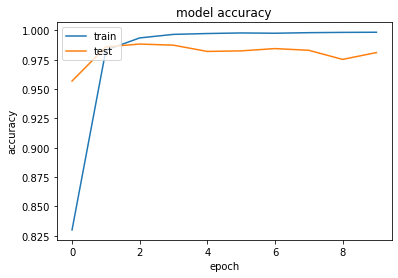

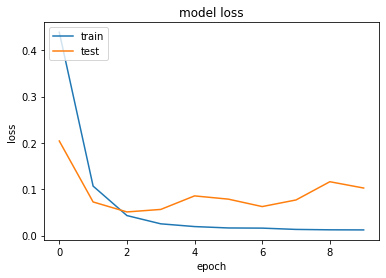

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9810954920019389

In [23]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='micro')

0.9810954920019389

In [24]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='micro')

0.9810954920019389

In [25]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='micro')

0.9810954920019389

[[1593   11]
 [  28  431]]


array([[1593,   11],
       [  28,  431]])

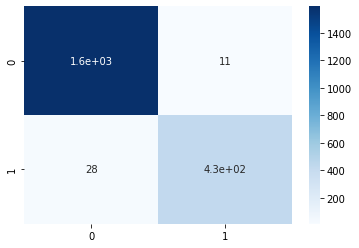

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred=model.predict(X_test) 
y_pred = (y_pred > 0.5)

conf=confusion_matrix(y_test,y_pred)

print(conf)

import seaborn as sn

sn.heatmap(conf, cmap="Blues", annot=True)# font size
conf
